# Imports and loads

In [115]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(434237, 27)


In [116]:
# pd.set_option('display.max_rows', None)
# display(df05ht[(df05ht['homeTeam'] == 'Grêmio Novorizontino') & (df05ht['awayTeam'] == 'Vancouver Whitecaps FC')])

In [117]:
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-22,10:26,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
1,2020-01-22,11:06,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
2,2020-01-22,11:45,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
3,2020-01-22,12:25,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
4,2020-01-22,13:04,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434232,2020-10-14,43:27,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,9.0,8.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434233,2020-10-14,44:07,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434234,2020-10-14,44:46,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434235,2020-10-14,45+0:26,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,11.0,10.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales


# Preprocessamento dos dados

## Limpeza

In [118]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)
df.drop(columns=['minute_converted']).drop_duplicates().to_csv('data_teste.csv', index=False, encoding='utf-8')

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (434237, 27)
Valores únicos de minutos antes da conversão: ['10:26' '11:06' '11:45' ... '41:07' '22:60' '17:38'] 

Registros duplicados: 0
Registros nulos: 0

Jogos que serão retirados: 0

Dimensão do DataFrame após remoção: (434237, 27)
Total de registros retirados: 0


In [119]:
# datas com minutos inválidos
datas = df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()
for data in datas:
    print(f"'{data}',", end=' ')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [120]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)
print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')


Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Tratando o formato das ligas para ligas existentes na API

In [121]:
# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Liga atual: South America - CONMEBOL Libertadores
Liga atual: Brazil - Paulista A1
Liga atual: Asia - AFC Champions League
Liga atual: Brazil - Supercopa do Brasil
Liga atual: Japan - J1 League
Liga atual: South America - CONMEBOL Sudamericana
Liga atual: USA - MLS
Liga atual: Brazil - Copa do Brasil
Liga atual: Germany - Play-offs 1/2
Liga atual: Mexico - Liga MX
Liga atual: Scotland - Premiership
Liga atual: Brazil - Serie A
Liga atual: France - Ligue 1
Liga atual: Europe - UEFA Champions League
Liga atual: England - League Cup
Liga atual: Europe - UEFA Nations League
Liga atual: England - Premier League
Liga atual: Germany - Bundesliga
Liga atual: Italy - Serie A
Liga atual: Italy - Serie B
Liga atual: Netherlands - Eredivisie
Liga atual: England - Championship
Liga atual: Spain - Primera División
Liga atual: Greece - Super League 1
Liga atual: South America - CONMEBOL World Cup Qualifiers
Liga atual: England - League One
Liga atual: England - League Two
Liga atual: Europe - UEFA Eu

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas por time: 1084

Balanceando dados...
Dados balanceados:

0.0    52071
1.0    52062
Name: result, dtype: int64

Filtrando dados de ligas...
Dados filtrados:

England - Premier League                  8170
USA - Major League Soccer                 8146
Brazil - Serie A                          5390
Argentina - Superliga                     5318
Spain - La Liga                           4396
Germany - Bundesliga                      4340
England - Championship                    3582
Italy - Serie A                           3458
South America - Copa Libertadores         3380
France - Ligue 1                          3338
England - League One                      3160
England - League Two                      3056
Europe - Champions League                 2922
Spain - La Liga 2                         2862
Mexico - Liga MX                          2786
Italy - Serie B                           2468
Australia - A-League                      2

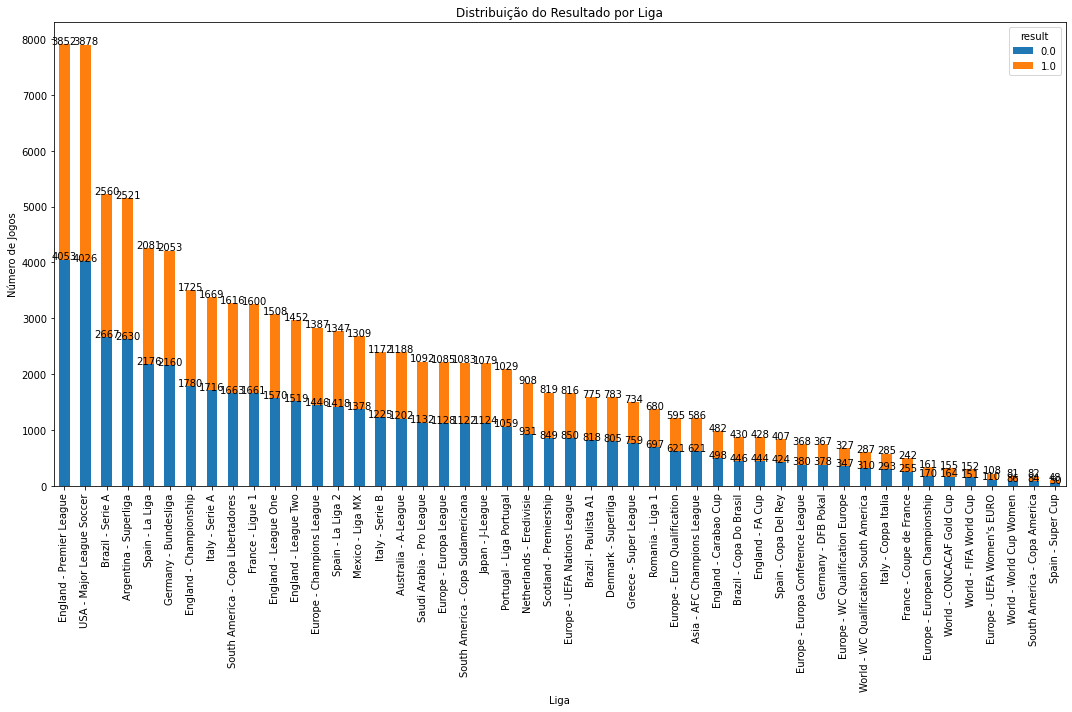

In [122]:
def count_matches(df, home_col, away_col):
    """Conta as partidas jogadas por cada time, tanto em casa quanto fora."""
    matches_home = df[home_col].value_counts()
    matches_away = df[away_col].value_counts()
    return matches_home.add(matches_away, fill_value=0)

def filter_leagues(df, league_col, result_col, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    ## Agrupando por liga e filtrando aquelas com menos de 100 jogos
    ligas_com_100_jogos = df.groupby(league_col).filter(lambda x: len(x) >= min_matches)

    # Filtrando as ligas que têm mais de um valor único em 'result'
    ligas_diversas = ligas_com_100_jogos.groupby(league_col).filter(lambda x: x[result_col].nunique() > 1)

    return ligas_diversas

def balance_data(df, liga_col='league', result_col='result'):
    # Agrupando por liga e balanceando os resultados dentro de cada grupo
    def balancear_grupo(grupo):
        # Encontrando a contagem mínima de valores em 'result'
        min_count = grupo[result_col].value_counts().min()

        # Amostragem de cada categoria em 'result' para ter a mesma contagem
        return grupo.groupby(result_col).apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    # Aplicando a função de balanceamento a cada liga
    df_balanceado = df.groupby(liga_col, group_keys=False).apply(balancear_grupo).reset_index(drop=True)

    return df_balanceado

# Aplicando as funções ao DataFrame original
print("Contando partidas por time...")
total_matches_per_team = count_matches(df, 'homeTeam', 'awayTeam')
print("Total de partidas por time:", len(total_matches_per_team))

print("\nBalanceando dados...")
balanced_data = balance_data(df, 'league', 'result')
df = balanced_data
print("Dados balanceados:\n")
print(df['result'].value_counts())

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'result')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())
df = filtered_data

df.drop_duplicates(keep='last', inplace=True)
df.dropna(inplace=True)

league_distribution = df.groupby(['league', 'result']).size().unstack().fillna(0)
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

# Iterando sobre as barras e adicionando anotações
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()


## Separação de Características, Transformação e Divisão de Dados

In [123]:
df.to_csv('data_balanced.csv', index=False, encoding='utf-8')

In [124]:
df.shape

(100788, 24)

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")


Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


# Modelos

## H2O AutoML: De Conversão de Dados a Treinamento, Carregamento e Salvamento de Modelos

In [128]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["col_" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["col_" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='auc')
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,4 hours 15 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 30 days
H2O_cluster_name:,H2O_from_python_Pichau_83fgch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.398 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (80630, 66)
y_train_h2o shape: (80630, 1)
X_test_h2o shape: (20158, 66)
y_test_h2o shape: (20158, 1)
AutoML progress: |█
07:13:50.333: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


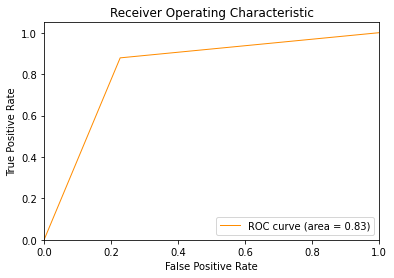

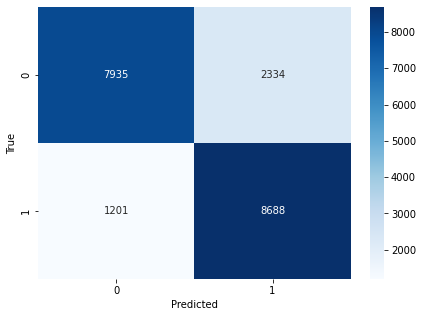

In [129]:
loaded_model = h2o.load_model("../models/model_automl")
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Na prática

In [130]:
# h2o.init()
loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.557667,0.442333


In [131]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.4423331880391245

## Treinamento e Avaliação de Modelo de Classificação Binária com Rede Neural no Keras

Iniciando a construção do modelo...
Treinando o modelo...
Epoch 1/500
1260/1260 [==============================] - 3s 2ms/step - loss: 0.6851 - accuracy: 0.5457 - recall: 0.5076 - val_loss: 0.6780 - val_accuracy: 0.5604 - val_recall: 0.5425
Epoch 2/500
1260/1260 [==============================] - 2s 1ms/step - loss: 0.6678 - accuracy: 0.5841 - recall: 0.5624 - val_loss: 0.6659 - val_accuracy: 0.5898 - val_recall: 0.5756
Epoch 3/500
1260/1260 [==============================] - 2s 1ms/step - loss: 0.6446 - accuracy: 0.6199 - recall: 0.6071 - val_loss: 0.6512 - val_accuracy: 0.6074 - val_recall: 0.5784
Epoch 4/500
1260/1260 [==============================] - 2s 1ms/step - loss: 0.6175 - accuracy: 0.6503 - recall: 0.6430 - val_loss: 0.6299 - val_accuracy: 0.6311 - val_recall: 0.7267
Epoch 5/500
1260/1260 [==============================] - 2s 1ms/step - loss: 0.5910 - accuracy: 0.6746 - recall: 0.6714 - val_loss: 0.6164 - val_accuracy: 0.6524 - val_recall: 0.7306
Epoch 6/500
1260/1260 [====

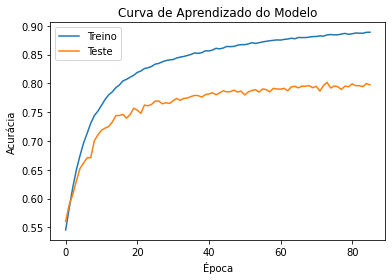

Salvando o modelo treinado...
Modelo salvo como 'model_redeht.h5'


In [127]:
print("Iniciando a construção do modelo...")
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Recall'])

# Configurando o Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
print("Treinando o modelo...")
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Fazendo as predições
print("Fazendo predições no conjunto de teste...")
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Salvando o modelo
print("Salvando o modelo treinado...")
model.save('../models/model_redeht.h5')
print("Modelo salvo como 'model_redeht.h5'")

## Treinamento e Avaliação de Modelo LSTM

In [ ]:
# # Supondo que cada sequência tenha um comprimento de 'seq_length' e 'n_features' características
# seq_length = 1
# n_features = X_train.shape[1]  # Altere isso de acordo com o número de características dos seus dados

# # Redimensionando X_train e X_test para o formato adequado para RNNs
# # Este passo é necessário porque RNNs esperam dados na forma de [samples, time steps, features]
# X_train_rnn = X_train.reshape((X_train.shape[0], seq_length, n_features))
# X_test_rnn = X_test.reshape((X_test.shape[0], seq_length, n_features))

# print("Iniciando a construção do modelo RNN...")
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(seq_length, n_features), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# # Compilando o modelo
# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Recall'])

# # Configurando o Early Stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=50)

# # Treinando o modelo
# print("Treinando o modelo RNN...")
# history = model.fit(X_train_rnn, y_train, epochs=500, batch_size=64, validation_data=(X_test_rnn, y_test), callbacks=[early_stop], verbose=1)

# # Fazendo as predições
# print("Fazendo predições no conjunto de teste...")
# predictions = model.predict(X_test_rnn)
# predictions = np.where(predictions > 0.5, 1, 0)

# # Avaliando a acurácia do modelo
# train_acc = model.evaluate(X_train_rnn, y_train, verbose=0)[1]
# test_acc = model.evaluate(X_test_rnn, y_test, verbose=0)[1]
# print('Acurácia no conjunto de treinamento:', train_acc)
# print('Acurácia no conjunto de teste:', test_acc)

# # Plotando a curva de aprendizado
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Curva de Aprendizado do Modelo RNN')
# plt.ylabel('Acurácia')
# plt.xlabel('Época')
# plt.legend(['Treino', 'Teste'], loc='upper left')
# plt.show()

# # Salvando o modelo
# print("Salvando o modelo RNN treinado...")
# model.save('../models/model_redeht_rnn.h5')
# print("Modelo RNN salvo como 'model_redeht_rnn.h5'")


Iniciando a construção do modelo RNN...
Treinando o modelo RNN...
Epoch 1/500
177/459 [==========>...................] - ETA: 27s - loss: 0.6933 - accuracy: 0.4974 - recall: 0.6090

KeyboardInterrupt: 